Our project's core problem is whether Crocs or Birkenstocks occupy the same customer niche in ugly yet comfortable slide-on shoes

In [2]:
#Dependencies
import pandas as pd
import hvplot.pandas
import numpy as np
import requests 
import json
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import plotly
import plotly.express as px
import re
from census import Census
import csv


#Import the API Key
from api_keys import google_api
from api_keys import census_key

# Census top cities

In [2]:
# Create an instance of the Census library
c = Census(census_key) 

# So may want to consider bounding it by the top 100 populus cities in the US or w/ pops over 400,000

# Load the CSV file created in Part 1 into a Pandas DataFrame
city_data_df = pd.read_csv("data/Census_City100.csv")

# Display sample data
city_data_df.head()

Rank         City        State  Population
0     1     New York     New York     8804190
1     2  Los Angeles   California     3893986
2     3      Chicago     Illinois     2747231
3     4      Houston        Texas     2302792
4     5      Phoenix      Arizona     1607739

# Google Trends

## Google Trends- over time (1 year)

In [3]:
 # Save config information for Birks
base_url = "https://serpapi.com/search?"


params = {"engine": "google_trends", 
          "q": "Birkenstocks",
          "data_type": "TIMESERIES",
          "geo": "US",
          "api_key": google_api}

# Run request
response = requests.get(base_url, params=params)
resp_data = response.json()

# Print the json (pretty printed)
#print(json.dumps(resp_data, indent=4, sort_keys=False))

# Need to divide the values data now
dates = resp_data["interest_over_time"]["timeline_data"]


# Flatten data
df_nested_list = pd.json_normalize(dates, record_path =['values'])

# To include dates and timestamp
df_nested_list = pd.json_normalize(
    dates, 
    record_path =['values'], 
    meta=['date', 'timestamp']
)

# Reorder list
df_nested_list= df_nested_list.iloc[:,[3,4, 0,1,2]]

In [4]:
 # Save config information for Crocs
croc_params = {"engine": "google_trends", 
          "q": "Crocs",
          "data_type": "TIMESERIES",
          "geo": "US",
          "api_key": google_api}

# Run request
c_response = requests.get(base_url, params=croc_params)
c_resp_data = c_response.json()

# Print the json (pretty printed)
#print(json.dumps(resp_data, indent=4, sort_keys=False))

# Need to divide the values data now
c_dates = c_resp_data["interest_over_time"]["timeline_data"]


# Flatten data
c_df_nested_list = pd.json_normalize(c_dates, record_path =['values'])

# To include dates and timestamp
c_df_nested_list = pd.json_normalize(
    c_dates, 
    record_path =['values'], 
    meta=['date', 'timestamp']
)


# Rename values to Crocs Value
# Column renaming
c_df_nested_list = c_df_nested_list.rename(
    columns = {
        "value" : "Croc Value",
        "extracted_value" : "Croc Extracted Value"})
# Reorder list
c_df_nested_list = c_df_nested_list.iloc[:,[3,4,1,2]]

In [5]:
# Append the two data frames
merged_time = pd.merge(df_nested_list, c_df_nested_list, on='date')
merged_time.head()

date timestamp_x         query value  extracted_value  \
0  Apr 10 – 16, 2022  1649548800  Birkenstocks    68               68   
1  Apr 17 – 23, 2022  1650153600  Birkenstocks    68               68   
2  Apr 24 – 30, 2022  1650758400  Birkenstocks    73               73   
3    May 1 – 7, 2022  1651363200  Birkenstocks    78               78   
4   May 8 – 14, 2022  1651968000  Birkenstocks    85               85   

  timestamp_y Croc Value  Croc Extracted Value  
0  1649548800         58                    58  
1  1650153600         52                    52  
2  1650758400         61                    61  
3  1651363200         91                    91  
4  1651968000         70                    70

In [6]:
# Column renaming
merged_time = merged_time.rename(
    columns = {
        "value" : "Birk Value",
        "extracted_value" : "Birk Extracted Value"})

# Need to change from object to numerics
merged_time["Birk Value"] = pd.to_numeric(merged_time["Birk Value"])
merged_time["Croc Value"] = pd.to_numeric(merged_time["Croc Value"])

In [7]:
# Reorder list
arranged_merged_time = merged_time.iloc[:,[0,3,4,6,7]]

In [8]:
arranged_merged_time.head()

date  Birk Value  Birk Extracted Value  Croc Value  \
0  Apr 10 – 16, 2022          68                    68          58   
1  Apr 17 – 23, 2022          68                    68          52   
2  Apr 24 – 30, 2022          73                    73          61   
3    May 1 – 7, 2022          78                    78          91   
4   May 8 – 14, 2022          85                    85          70   

   Croc Extracted Value  
0                    58  
1                    52  
2                    61  
3                    91  
4                    70

In [9]:
 # Save the DataFrame as a CSV
# Note: To avoid any issues later, use encoding="utf-8"
arranged_merged_time.to_csv("data/arranged_merged_time.csv")

In [14]:
# Load the CSV file created in Part 1 into a Pandas DataFrame
trends_df = pd.read_csv("Noelle_analysis/data/arranged_merged_time_cor.csv") # added fixed date in excel using concotonate

# Display sample data
trends_df.head()

Index             date  Birk Value  Birk Extracted Value  Croc Value  \
0      0  Apr 10-16, 2022          69                    69          66   
1      1  Apr 17-23, 2022          69                    69          56   
2      2  Apr 24-30, 2022          73                    73          68   
3      3    May 1-7, 2022          77                    77          96   
4      4   May 8-14, 2022          84                    84          74   

   Croc Extracted Value Month  Date  Year Corrected_Date  
0                    66   Apr    10  2022    Apr/10/2022  
1                    56   Apr    17  2022    Apr/17/2022  
2                    68   Apr    24  2022    Apr/24/2022  
3                    96   May     1  2022     May/1/2022  
4                    74   May     8  2022     May/8/2022

In [15]:
trends_df["fixed_date"] = pd.to_datetime(trends_df["Corrected_Date"])

In [16]:
trends_df.dtypes

Index                            int64
date                            object
Birk Value                       int64
Birk Extracted Value             int64
Croc Value                       int64
Croc Extracted Value             int64
Month                           object
Date                             int64
Year                             int64
Corrected_Date                  object
fixed_date              datetime64[ns]
dtype: object

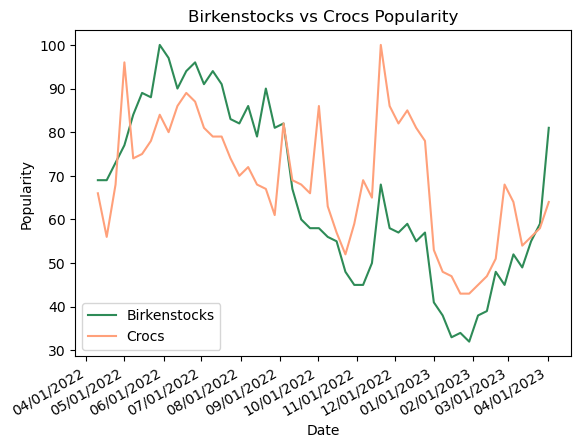

In [17]:
x = trends_df['fixed_date']
y1 = trends_df['Birk Value']
y2 = trends_df['Croc Value']

plt.plot(x, y1, "seagreen", label="Birkenstocks")
plt.plot(x, y2, "lightsalmon", label="Crocs")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())


# Add labels and title to plot
plt.xlabel("Date")
plt.ylabel("Popularity")
plt.title("Birkenstocks vs Crocs Popularity")
plt.legend(loc="lower left")

plt.gcf().autofmt_xdate()

plt.savefig("images/GoogleTrends.png")


## Google Trends - by state (maps & graphs)

In [18]:
# Save config information
base_url = "https://serpapi.com/search?"


params = {"engine": "google_trends", 
          "q": "Birkenstocks",
          "data_type": "GEO_MAP_0",
          "geo": "US",
          "api_key": google_api}

# Run request
response = requests.get(base_url, params=params)
resp_data = response.json()

# Print the json (pretty printed)
#print(json.dumps(resp_data, indent=4, sort_keys=False))

In [19]:
# Birks
birk_trends = resp_data["interest_by_region"]
# Convert to DataFrame
birk_trends = pd.DataFrame(birk_trends)

# Column renaming
birk_trends = birk_trends.rename(
    columns = {
        "location" : "State",
        "max_value_index": "Birk max value index",
        "value": "Birk value",
        "extracted_value": "Birk extracted value",

    }
)

# Crocs
params = {"engine": "google_trends", 
          "q": "Crocs",
          "data_type": "GEO_MAP_0",
          "geo": "US",
          "api_key": google_api}

# Run request
response1 = requests.get(base_url, params=params)
resp_data1 = response1.json()

croc_trends = resp_data1["interest_by_region"]

# Convert to DataFrame
croc_trends = pd.DataFrame(croc_trends)

# Column renaming
croc_trends = croc_trends.rename(
    columns = {
        "location" : "State",
        "max_value_index": "Croc max value index",
        "value": "Croc value",
        "extracted_value": "Croc extracted value",

    }
)

In [20]:
# Append the two data frames
merged_trends = pd.merge(birk_trends, croc_trends, on='State')

merged_trends.head()

geo_x         State  Birk max value index Birk value  Birk extracted value  \
0  US-VT       Vermont                     0        100                   100   
1  US-ID         Idaho                     0         96                    96   
2  US-SD  South Dakota                     0         95                    95   
3  US-MN     Minnesota                     0         91                    91   
4  US-IA          Iowa                     0         91                    91   

   geo_y  Croc max value index Croc value  Croc extracted value  
0  US-VT                     0         51                    51  
1  US-ID                     0         41                    41  
2  US-SD                     0         35                    35  
3  US-MN                     0         52                    52  
4  US-IA                     0         42                    42

In [21]:
 # Save the DataFrame as a CSV
merged_trends.to_csv("data/merged_trends.csv")

In [22]:
d = pd.DataFrame(merged_trends, columns = ["State"])
states = {
        'AK': 'Alaska',
        'AL': 'Alabama',
        'AR': 'Arkansas',
        'AS': 'American Samoa',
        'AZ': 'Arizona',
        'CA': 'California',
        'CO': 'Colorado',
        'CT': 'Connecticut',
        'DC': 'District of Columbia',
        'DE': 'Delaware',
        'FL': 'Florida',
        'GA': 'Georgia',
        'GU': 'Guam',
        'HI': 'Hawaii',
        'IA': 'Iowa',
        'ID': 'Idaho',
        'IL': 'Illinois',
        'IN': 'Indiana',
        'KS': 'Kansas',
        'KY': 'Kentucky',
        'LA': 'Louisiana',
        'MA': 'Massachusetts',
        'MD': 'Maryland',
        'ME': 'Maine',
        'MI': 'Michigan',
        'MN': 'Minnesota',
        'MO': 'Missouri',
        'MP': 'Northern Mariana Islands',
        'MS': 'Mississippi',
        'MT': 'Montana',
        'NA': 'National',
        'NC': 'North Carolina',
        'ND': 'North Dakota',
        'NE': 'Nebraska',
        'NH': 'New Hampshire',
        'NJ': 'New Jersey',
        'NM': 'New Mexico',
        'NV': 'Nevada',
        'NY': 'New York',
        'OH': 'Ohio',
        'OK': 'Oklahoma',
        'OR': 'Oregon',
        'PA': 'Pennsylvania',
        'PR': 'Puerto Rico',
        'RI': 'Rhode Island',
        'SC': 'South Carolina',
        'SD': 'South Dakota',
        'TN': 'Tennessee',
        'TX': 'Texas',
        'UT': 'Utah',
        'VA': 'Virginia',
        'VI': 'Virgin Islands',
        'VT': 'Vermont',
        'WA': 'Washington',
        'WI': 'Wisconsin',
        'WV': 'West Virginia',
        'WY': 'Wyoming'
}

def best_match(x):
    if len(x) == 2: # Try another way for 2-letter codes
        for a,n in states.items():
            if len(n.split()) == 2:
                if "".join([c[0] for c in n.split()]).lower() == x.lower():
                    return a.lower()
    new_rx = re.compile(r"\w*".join([ch for ch in x]), re.I)
    for a,n in states.items():
        if new_rx.match(n):
            return a.upper()
        
d['state_code'] = d['State'].apply(lambda x: best_match(x))

In [23]:
# Append the two data frames
merged_trends = pd.merge(merged_trends, d, on='State')

In [24]:
# Are the croc/birk values numerics?
# merged_trends.dtypes

# Need to change from object to numerics
merged_trends["Birk value"] = pd.to_numeric(merged_trends["Birk value"])
merged_trends["Croc value"] = pd.to_numeric(merged_trends["Croc value"])

In [25]:
fig = px.choropleth(merged_trends,
                    locations='state_code', 
                    locationmode="USA-states", 
                    scope="usa",
                    color='Birk value',
                    color_continuous_scale="viridis_r"
                    )

fig.update_layout(
      title_text = 'April 2023 Birkenstock Trend Popularity by State',
      title_font_family="Helvetica",
      title_font_size = 22,
      title_font_color="black", 
      title_x=0.45, 
         )

fig.show()

In [26]:
fig2 = px.choropleth(merged_trends,
                    locations='state_code', 
                    locationmode="USA-states", 
                    scope="usa",
                    color='Croc value',
                    color_continuous_scale="viridis_r"
                    )

fig2.update_layout(
      title_text = 'April 2023 Crocs Trend Popularity by State',
      title_font_family="Helvetica",
      title_font_size = 22,
      title_font_color="black", 
      title_x=0.45, 
         )

fig2.show()

In [27]:
# If you need to save this file as a standalone html file:
fig.write_html("images/choropleth-map-birk.html")
fig2.write_html("images/choropleth-map-croc.html")

In [28]:
merged_trends.head()

geo_x         State  Birk max value index  Birk value  \
0  US-VT       Vermont                     0         100   
1  US-ID         Idaho                     0          96   
2  US-SD  South Dakota                     0          95   
3  US-MN     Minnesota                     0          91   
4  US-IA          Iowa                     0          91   

   Birk extracted value  geo_y  Croc max value index  Croc value  \
0                   100  US-VT                     0          51   
1                    96  US-ID                     0          41   
2                    95  US-SD                     0          35   
3                    91  US-MN                     0          52   
4                    91  US-IA                     0          42   

   Croc extracted value state_code  
0                    51         VT  
1                    41         ID  
2                    35         SD  
3                    52         MN  
4                    42         IA

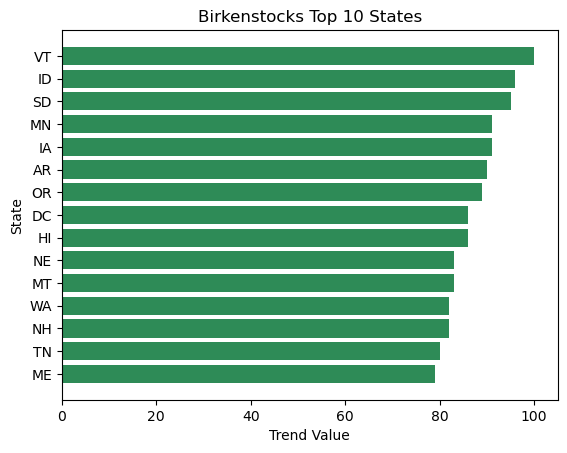

In [29]:
# Top states
# Birks: VT, ID, SD, IA, HI, MN, AR, OR, WA, DC
# Crocs: TX, MD, DE, CA, GA, NV, FL, HI, AZ, IL

# Birks
birk_city_df = merged_trends.loc[(merged_trends["Birk value"] >= 78)].dropna()

x1 = birk_city_df['state_code']
y1 = birk_city_df['Birk value']

chart2 = plt.barh(x1, y1, color = "seagreen")

# Give our chart some labels and a tile
plt.ylabel("State")
plt.xlabel("Trend Value")
plt.title("Birkenstocks Top 10 States")
plt.xticks(rotation="horizontal")
plt.gca().invert_yaxis()
plt.savefig("images/BirkStateTrends.png")

plt.show()

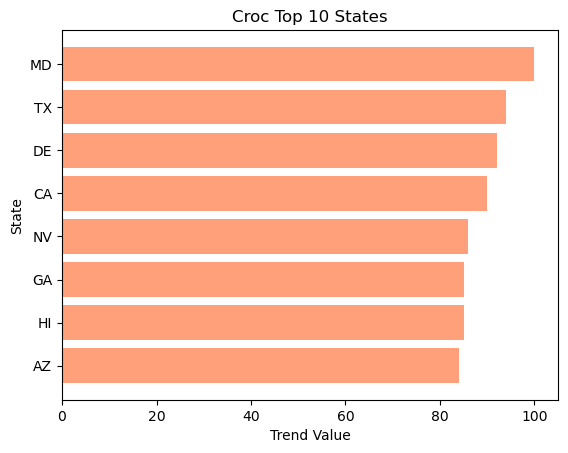

In [30]:
# Crocs
croc_city_df = merged_trends.loc[(merged_trends["Croc value"] >= 84)].dropna()
croc_city_df = croc_city_df.sort_values("Croc value")
x2 = croc_city_df['state_code']
y2 = croc_city_df['Croc value']

chart3 = plt.barh(x2, y2, color = "lightsalmon")

# Give our chart some labels and a tile
plt.ylabel("State")
plt.xlabel("Trend Value")
plt.title("Croc Top 10 States")
#plt.gca().invert_yaxis()

plt.savefig("images/CrocStateTrends.png")

plt.show()

# Google Shopping Results

In [5]:
#Shopping Birks
base_url="https://serpapi.com/search"

params = {"engine": "google_shopping",
          "q": "Birkenstocks",
          "api_key": google_api}
# Run request
response= requests.get(base_url, params=params)
resp_data = response.json()
# Print the json (pretty printed)
#print(json.dumps(resp_data, indent=4, sort_keys=False))

sub = resp_data["shopping_results"]
# Convert to DataFrame
birk = pd.DataFrame(sub)

birk.head()

position                                              title  \
0         1                  Birkenstock Arizona Sandals Mocca   
1         2  Women's Birkenstock Arizona Essentials Slide S...   
2         3  Birkenstock Arizona Narrow Width in Mocha, Siz...   
3         4                   Birkenstock Arizona 1021201 Pink   
4         5                  Birkenstock Black Arizona Sandals   

                                                link  \
0  https://www.birkenstock.com/us/arizona-birko-f...   
1  https://www.dsw.com/en/us/product/birkenstock-...   
2  https://www.rei.com/product/112591/birkenstock...   
3  https://www.6pm.com/product/9525867/color/5548...   
4  https://www.pavidas.com/en/product/birkenstock...   

                                        product_link           product_id  \
0  https://www.google.com/shopping/product/802308...  8023085328904509767   
1  https://www.google.com/shopping/product/284798...  2847988703576388086   
2  https://www.google.com/shopping/product/327168...  3271683418676022487   
3  https://www.google.com/shopping/product/948495...  9484953065851617546   
4  https://www.google.com/shopping/product/370790...  3707907262975491913   

                                 serpapi_product_api       source   price  \
0  https://serpapi.com/search.json?device=desktop...  BIRKENSTOCK  $59.95   
1  https://serpapi.com/search.json?device=desktop...          DSW  $49.99   
2  https://serpapi.com/search.json?device=desktop...          REI  $59.95   
3  https://serpapi.com/search.json?device=desktop...      6pm.com  $24.75   
4  https://serpapi.com/search.json?device=desktop...      Pavidas  $66.00   

   extracted_price  rating  ...  \
0            59.95     4.7  ...   
1            49.99     4.6  ...   
2            59.95     4.6  ...   
3            24.75     4.8  ...   
4            66.00     4.7  ...   

                                        delivery store_rating store_reviews  \
0                                 $4.95 delivery          4.4          36.0   
1                        Delivery by Thu, Apr 20          4.9          65.0   
2                                  Free delivery          4.9         656.0   
3  Delivery by Tue, Apr 18 · Free 30-day returns          4.9           NaN   
4                                $40.00 delivery          NaN           NaN   

   number_of_comparisons                                    comparison_link  \
0                    NaN                                                NaN   
1                    10+  https://www.google.com/shopping/product/284798...   
2                    20+  https://www.google.com/shopping/product/327168...   
3                     5+  https://www.google.com/shopping/product/948495...   
4                     5+  https://www.google.com/shopping/product/370790...   

                     serpapi_product_api_comparisons          badge  tag  \
0                                                NaN            NaN  NaN   
1  https://serpapi.com/search.json?engine=google_...  Trusted store  NaN   
2  https://serpapi.com/search.json?engine=google_...  Trusted store  NaN   
3  https://serpapi.com/search.json?engine=google_...  Trusted store  NaN   
4  https://serpapi.com/search.json?engine=google_...            NaN  NaN   

  extensions alternative_price  
0        NaN               NaN  
1        NaN               NaN  
2        NaN               NaN  
3        NaN               NaN  
4        NaN               NaN  

[5 rows x 22 columns]

In [8]:
# Column renaming for birkenstocks
birk= birk.rename(
    columns = {
        "title" : "Product name",
        "source": "Selling Source",
        "price": "Price ($)",
        "extracted_price": "Extracted Price",
        "rating": "Rating",
        "reviews": "Reviews",

    }
)


# Configure the final DataFrame
birk = birk[
    [
        "Product name", 
        "Selling Source",
        "Price ($)",
        "Extracted Price",
        "Rating",
        "Reviews",
    ]
]


In [9]:
#fill the na values with 0's 
birk["Reviews"].fillna(0,inplace=True)
birk["Rating"].fillna(0,inplace=True)
birk.Reviews=birk.Reviews.astype(int)
birk["Price ($)"]=birk["Price ($)"].str.replace("$","").astype(float)

/var/folders/4y/bplz9gkx115983933b15hd8r0000gp/T/ipykernel_62216/117095173.py:5: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  birk["Price ($)"]=birk["Price ($)"].str.replace("$","").astype(float)


In [10]:
birk.head()

Product name Selling Source  \
0                  Birkenstock Arizona Sandals Mocca    BIRKENSTOCK   
1  Women's Birkenstock Arizona Essentials Slide S...            DSW   
2  Birkenstock Arizona Narrow Width in Mocha, Siz...            REI   
3                   Birkenstock Arizona 1021201 Pink        6pm.com   
4                  Birkenstock Black Arizona Sandals        Pavidas   

   Price ($)  Extracted Price  Rating  Reviews  
0      59.95            59.95     4.7      151  
1      49.99            49.99     4.6    14162  
2      59.95            59.95     4.6      196  
3      24.75            24.75     4.8        8  
4      66.00            66.00     4.7     9710

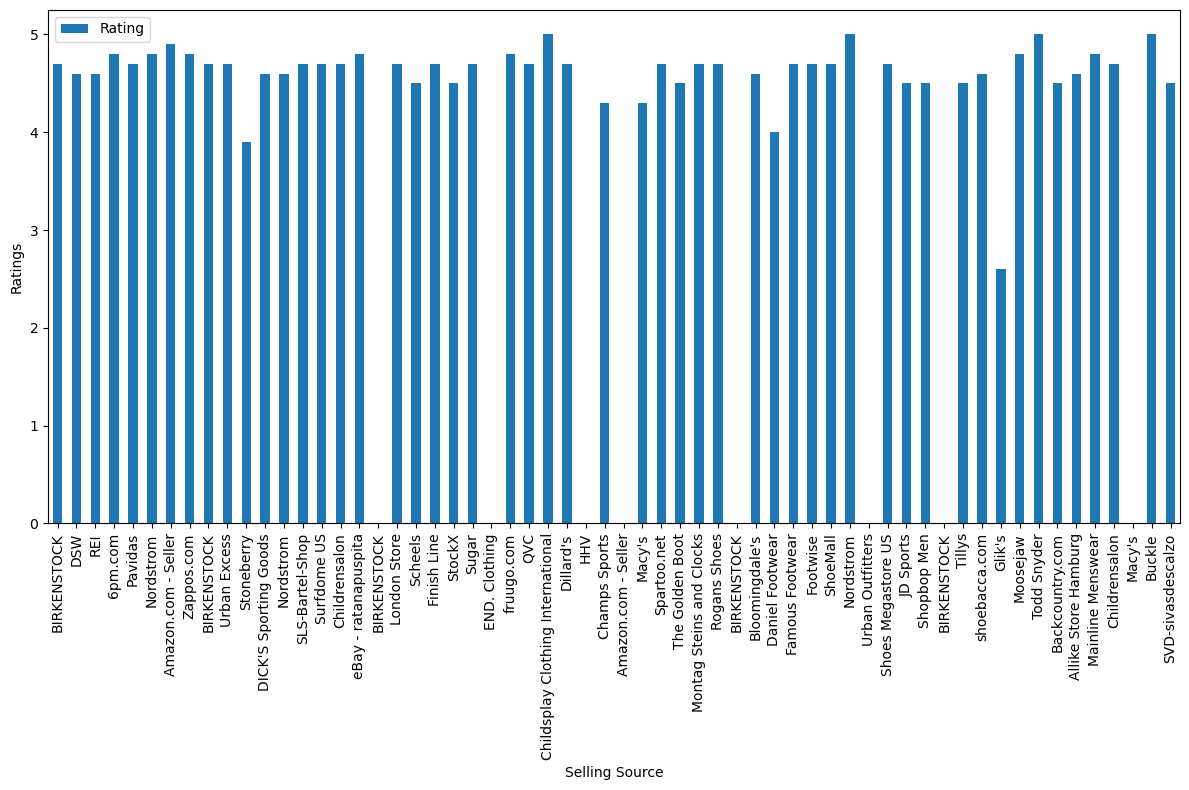

In [12]:
#Creating birk bar graph to check data 
df_rating=birk[["Selling Source","Rating"]].copy()
df_rating.set_index("Selling Source", inplace=True)
df_rating.plot(kind="bar",rot=90,figsize=(12,8))
plt.ylabel("Ratings")
plt.tight_layout()
plt.savefig("ratingplot.png")
plt.show()

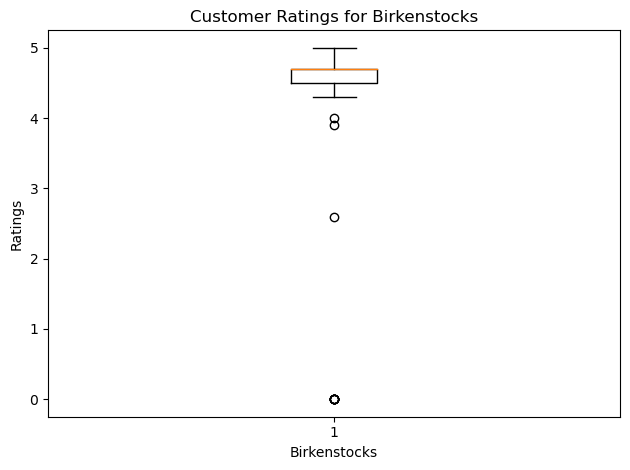

In [13]:
#Creating just a birk box plot
plt.boxplot(df_rating, 0)
plt.title("Customer Ratings for Birkenstocks")
plt.ylabel("Ratings")
plt.xlabel("Birkenstocks")
plt.tight_layout()
plt.savefig("birkratingboxplot.png")
plt.show()

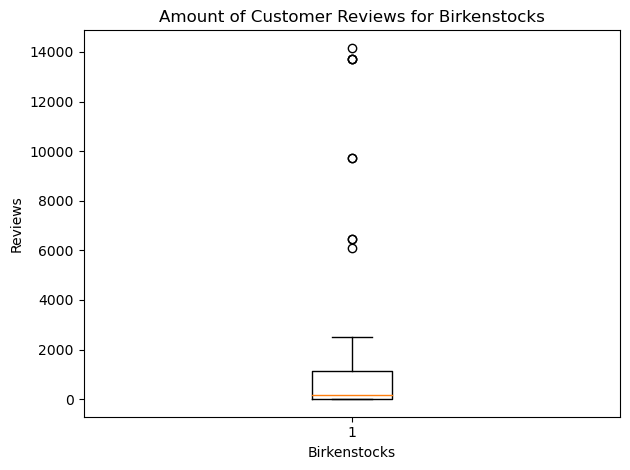

In [15]:
#Creating just a birk reviews 
df_reviews=birk[["Selling Source","Reviews"]].copy()
df_reviews.set_index("Selling Source", inplace=True)
plt.boxplot(df_reviews, 0)
plt.title("Amount of Customer Reviews for Birkenstocks")
plt.ylabel("Reviews")
plt.xlabel("Birkenstocks")
plt.tight_layout()
plt.savefig("birkreviewsboxplot.png")
plt.show()

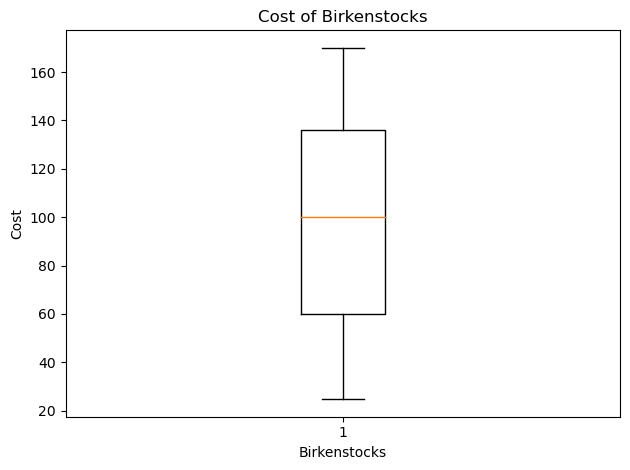

In [16]:
#Creating a birk price
df_price=birk[["Selling Source","Price ($)"]].copy()
df_price.set_index("Selling Source", inplace=True)
plt.boxplot(df_price, 0)
plt.title("Cost of Birkenstocks")
plt.ylabel("Cost")
plt.xlabel("Birkenstocks")
plt.tight_layout()
plt.savefig("birkcostboxplot.png")
plt.show()

In [18]:
#Shopping Crocs
base_url="https://serpapi.com/search"

params = {"engine": "google_shopping",
          "q": "Crocs",
          "api_key": google_api}
# Run request
response= requests.get(base_url, params=params)
resp_data = response.json()
# Print the json (pretty printed)
#print(json.dumps(resp_data, indent=4, sort_keys=False))
sub= resp_data["shopping_results"]
# Convert to DataFrame
croc = pd.DataFrame(sub)

In [19]:
# Column renaming
croc = croc.rename(
    columns = {
        "title" : "Product name",
        "source": "Selling Source",
        "price": "Price ($)",
        "extracted_price": "Extracted Price",
        "rating": "Rating",
        "reviews": "Reviews",

    }
)


# Configure the final DataFrame
croc = croc[
    [
        "Product name", 
        "Selling Source",
        "Price ($)",
        "Extracted Price",
        "Rating",
        "Reviews",
    ]
]

In [20]:
#fill the na values with 0's 
croc["Reviews"].fillna(0,inplace=True)
croc["Rating"].fillna(0,inplace=True)
croc.Reviews=croc.Reviews.astype(int)
croc["Price ($)"]=croc["Price ($)"].str.replace("$","").astype(float)

/var/folders/4y/bplz9gkx115983933b15hd8r0000gp/T/ipykernel_62216/567252238.py:5: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  croc["Price ($)"]=croc["Price ($)"].str.replace("$","").astype(float)


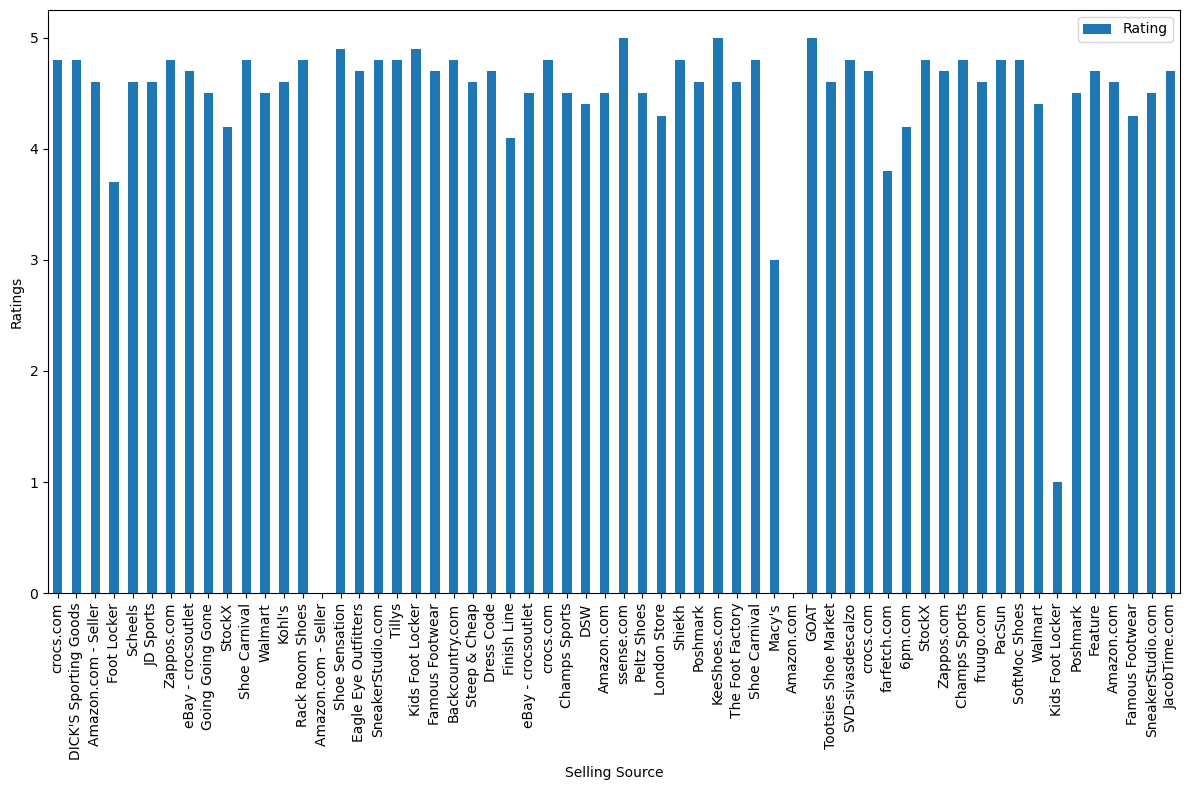

In [21]:
#Crocs rating displayed in bar graph
df_rating=croc[["Selling Source","Rating"]].copy()
df_rating.set_index("Selling Source", inplace=True)
df_rating.plot(kind="bar",rot=90,figsize=(12,8))
plt.ylabel("Ratings")
plt.tight_layout()
plt.savefig("crocratingplot.png")
plt.show()

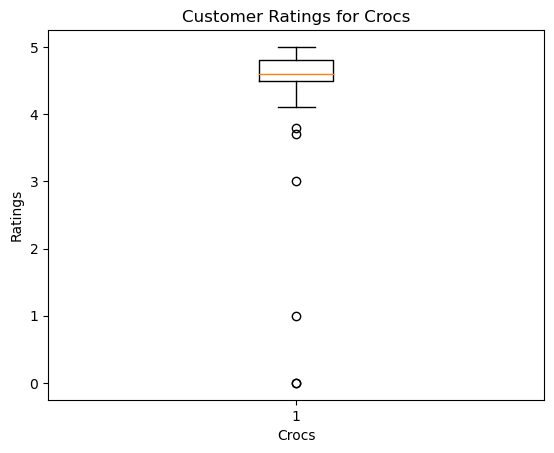

In [22]:
#Crocs box plot displaying ratings 
plt.boxplot(df_rating,0)
plt.title("Customer Ratings for Crocs")
plt.ylabel("Ratings")
plt.xlabel("Crocs")
plt.savefig("crocratingboxplot.png")
plt.show()

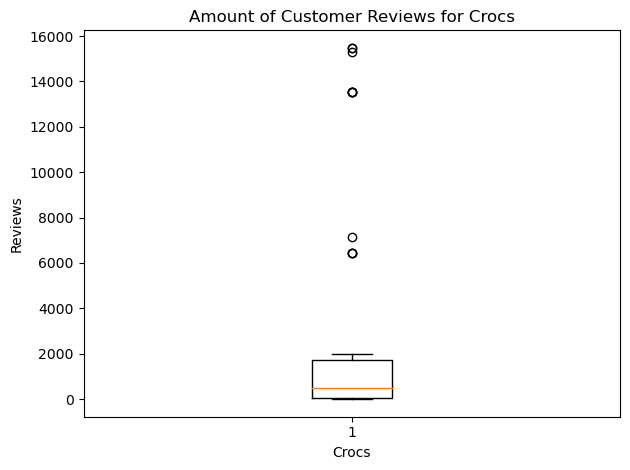

In [23]:
#Crocs data for reviews vs selling source
df_reviews=croc[["Selling Source","Reviews"]].copy()
df_reviews.set_index("Selling Source", inplace=True)
plt.boxplot(df_reviews, 0)
plt.title("Amount of Customer Reviews for Crocs")
plt.ylabel("Reviews")
plt.xlabel("Crocs")
plt.tight_layout()
plt.savefig("crocreviewsboxplot.png")
plt.show()

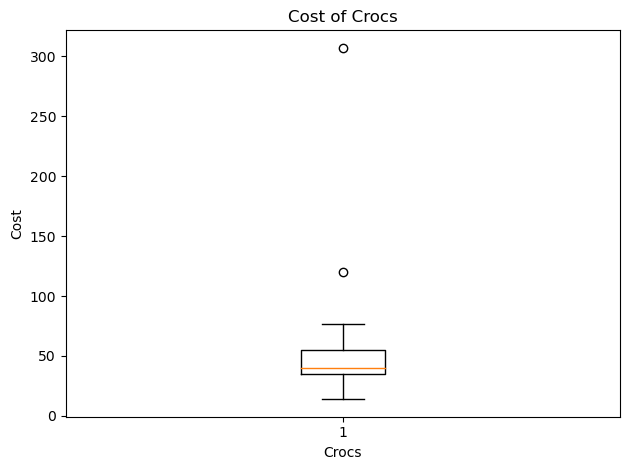

In [24]:
#Crocs selling source vs Price
df_price=croc[["Selling Source","Price ($)"]].copy()
df_price.set_index("Selling Source", inplace=True)
plt.boxplot(df_price, 0)
plt.title("Cost of Crocs")
plt.ylabel("Cost")
plt.xlabel("Crocs")
plt.tight_layout()
plt.savefig("croccostboxplot.png")
plt.show()

## Taking the Shopping Data and Merging to Show Comparions together


In [25]:
#Merge the two Data Frames together 
croc_birk_df=pd.merge(birk,croc,on='Selling Source')
croc_birk_df.tail()

Product name_x     Selling Source  \
20  Birkenstock Women's Sydney Graceful Taupe Birk...    Famous Footwear   
21        Birkenstock Boston Soft Footbed Suede Taupe          JD Sports   
22  Birkenstock Women's Zermatt Shearling Light Gr...             Tillys   
23  Birkenstock Arizona Sandal - Girls' Electric M...    Backcountry.com   
24                      Birkenstock Arizona EVA Green  SVD-sivasdescalzo   

    Price ($)_x  Extracted Price_x  Rating_x  Reviews_x  \
20        99.99              99.99       4.7         40   
21       158.00             158.00       4.5       1138   
22        99.99              99.99       4.5        391   
23        59.95              59.95       4.5       6087   
24        28.00              28.00       4.5       6459   

                                       Product name_y  Price ($)_y  \
20                  Crocs Classic Clog Margaritaville        59.99   
21                Crocs Classic Clog 10001 Taffy Pink        37.50   
22  Crocs Unisex Classic Retro Resort Clog - Bone/...        54.99   
23  Adults' Crocs Classic Lined Clogs in Lavender/...        29.98   
24                         Crocs Classic Clog K Green        19.25   

    Extracted Price_y  Rating_y  Reviews_y  
20              59.99       4.3        144  
21              37.50       4.6      13555  
22              54.99       4.8        532  
23              29.98       4.8       6424  
24              19.25       4.8       1594

In [26]:
#Save the Data Frame as a CSV File
croc_birk_df.to_csv("data/croc_birk_merged.csv")

In [27]:
#Remove Extracted Price since I did not need to use that
croc_birk_df.drop('Extracted Price_x',axis=1, inplace=True)
croc_birk_df.drop('Extracted Price_y',axis=1, inplace=True)


In [28]:
# Column renaming
croc_birk_df = croc_birk_df.rename(
    columns = {
        "Product name_x" : "Birkenstock Products",
        "Selling Source" : "Selling Source",
        "Price ($)_x": "Birkenstock Price",
        "Rating_x": "Birkenstock Ratings",
        "Reviews_x":"Birkenstock Reviews",
        "Product name_y" : "Croc Products",
        "Selling Source" : "Selling Source",
        "Price ($)_y": "Crocs Price",
        "Rating_y": "Crocs Ratings",
        "Reviews_y":"Crocs Reviews",})
croc_birk_df.head()

Birkenstock Products       Selling Source  \
0  Women's Birkenstock Arizona Essentials Slide S...                  DSW   
1                   Birkenstock Arizona 1021201 Pink              6pm.com   
2                  Birkenstock Mocca Arizona Sandals  Amazon.com - Seller   
3                  Birkenstock Mocca Arizona Sandals  Amazon.com - Seller   
4          Birkenstock Women's, Mayari Thong Sandals  Amazon.com - Seller   

   Birkenstock Price  Birkenstock Ratings  Birkenstock Reviews  \
0              49.99                  4.6                14162   
1              24.75                  4.8                    8   
2             101.05                  4.9                  346   
3             101.05                  4.9                  346   
4              65.00                  0.0                    0   

                                       Croc Products  Crocs Price  \
0                               Crocs Bistro (Black)        49.99   
1  Crocs Men's Clog Black & White Disco Classic C...        32.97   
2                            Crocs Classic Clog Bone        34.95   
3                    Crocs Unisex-Adult Classic Clog        25.00   
4                            Crocs Classic Clog Bone        34.95   

   Crocs Ratings  Crocs Reviews  
0            4.4           1865  
1            4.2             22  
2            4.6          13555  
3            0.0              0  
4            4.6          13555

In [29]:
#Save the Data Frame as a CSV File
croc_birk_df.to_csv("data/croc_birk_df_cleaned.csv")

In [30]:
#data format
croc_birk_df.dtypes

Birkenstock Products     object
Selling Source           object
Birkenstock Price       float64
Birkenstock Ratings     float64
Birkenstock Reviews       int64
Croc Products            object
Crocs Price             float64
Crocs Ratings           float64
Crocs Reviews             int64
dtype: object

In [31]:
#Convert the floats to ints
croc_birk_df['Birkenstock Price'] = croc_birk_df['Birkenstock Price'].apply(np.int64)
croc_birk_df['Crocs Price'] = croc_birk_df['Crocs Price'].apply(np.int64)
croc_birk_df['Birkenstock Ratings'] = croc_birk_df['Birkenstock Ratings'].apply(np.int64)
croc_birk_df['Crocs Ratings'] = croc_birk_df['Crocs Ratings'].apply(np.int64)
display(croc_birk_df.dtypes)

Birkenstock Products    object
Selling Source          object
Birkenstock Price        int64
Birkenstock Ratings      int64
Birkenstock Reviews      int64
Croc Products           object
Crocs Price              int64
Crocs Ratings            int64
Crocs Reviews            int64
dtype: object

[]

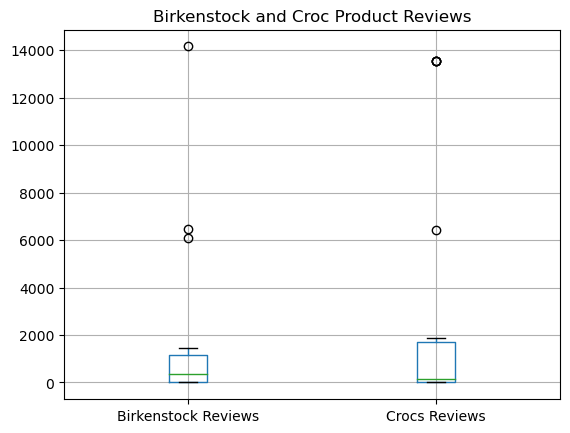

In [33]:
#Create a boxplot to show the comparison of Reviews for Crocs vs. Birks
bc_review=croc_birk_df.boxplot(column = ['Birkenstock Reviews', 'Crocs Reviews']) 
plt.title("Birkenstock and Croc Product Reviews")
plt.savefig("data/reviews.png")
bc_review.plot() 

The r-squared is: 0.00011398870182765485


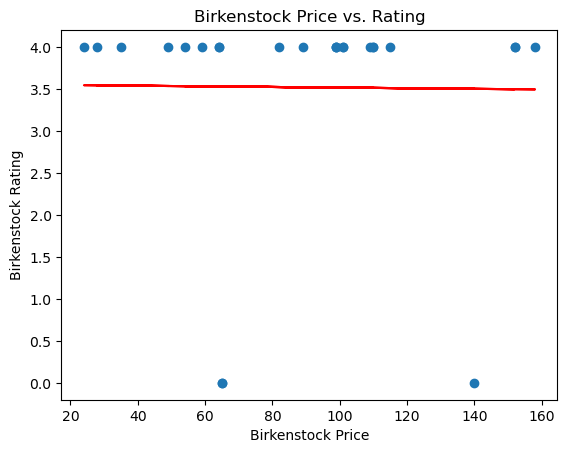

In [35]:
from scipy.stats import linregress
# Showing Ratings vs Price for Birk using line regress 
x_values = croc_birk_df['Birkenstock Price']
y_values = croc_birk_df['Birkenstock Ratings']
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(0,50),fontsize=15,color="red")
plt.xlabel('Birkenstock Price')
plt.ylabel('Birkenstock Rating')
plt.title("Birkenstock Price vs. Rating")
print(f"The r-squared is: {rvalue**2}")
plt.savefig("data/birk_rating_price.png")
plt.show()

The r-squared is: 0.028118853878624537


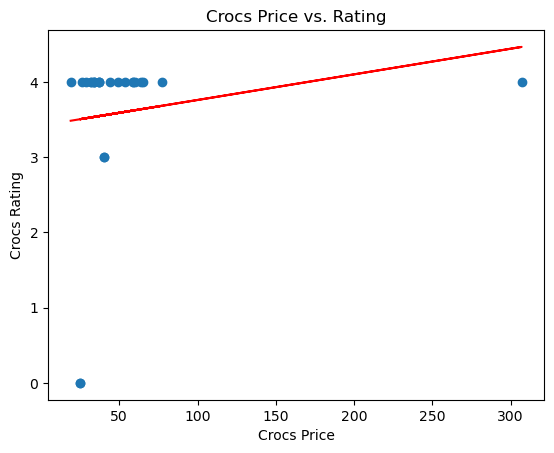

In [36]:
# Showing Ratings vs Price for Croc
x_values = croc_birk_df['Crocs Price']
y_values = croc_birk_df['Crocs Ratings']
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(0,50),fontsize=15,color="red")
plt.xlabel('Crocs Price')
plt.ylabel('Crocs Rating')
plt.title("Crocs Price vs. Rating")
print(f"The r-squared is: {rvalue**2}")
plt.savefig("data/croc_rating_price.png")
plt.show()

In [39]:
croc_birk_df.reset_index()

index                               Birkenstock Products  \
0       0  Women's Birkenstock Arizona Essentials Slide S...   
1       1                   Birkenstock Arizona 1021201 Pink   
2       2                  Birkenstock Mocca Arizona Sandals   
3       3                  Birkenstock Mocca Arizona Sandals   
4       4          Birkenstock Women's, Mayari Thong Sandals   
5       5          Birkenstock Women's, Mayari Thong Sandals   
6       6  Birkenstock Women's Arizona Birko-Flor Sandal,...   
7       7  Birkenstock Women's Arizona Birko-Flor Sandal,...   
8       8  Birkenstock Women's Arizona Slide Sandal, Moch...   
9       9  Birkenstock Milano Birko Flor Nubuck Sandals -...   
10     10  Birkenstock Arizona Eva Multi Gold Women's, 36...   
11     11  Birkenstock Women's Arizona Split Sandals, Bla...   
12     12   Birkenstock Boston Soft Footbed Suede Taupe / 46   
13     13   Birkenstock Boston Soft Footbed Suede Taupe / 46   
14     14       Birkenstock - MADRID_BIRKO-FLOR - Brown / 35   
15     15    Birkenstock Women's Arizona Pink Wool Shearling   
16     16    Birkenstock Women's Arizona Pink Wool Shearling   
17     17      Birkenstock Kids' Arizona Eva Beetroot Purple   
18     18  Birkenstock Women's Arizona Birko-Flor Soft Fo...   
19     19  Birkenstock Women's Sydney Graceful Taupe Birk...   
20     20  Birkenstock Women's Sydney Graceful Taupe Birk...   
21     21        Birkenstock Boston Soft Footbed Suede Taupe   
22     22  Birkenstock Women's Zermatt Shearling Light Gr...   
23     23  Birkenstock Arizona Sandal - Girls' Electric M...   
24     24                      Birkenstock Arizona EVA Green   

           Selling Source  Birkenstock Price  Birkenstock Ratings  \
0                     DSW                 49                    4   
1                 6pm.com                 24                    4   
2     Amazon.com - Seller                101                    4   
3     Amazon.com - Seller                101                    4   
4     Amazon.com - Seller                 65                    0   
5     Amazon.com - Seller                 65                    0   
6              Zappos.com                110                    4   
7              Zappos.com                110                    4   
8   DICK'S Sporting Goods                109                    4   
9            London Store                 82                    4   
10                Scheels                 54                    4   
11            Finish Line                115                    4   
12                 StockX                152                    4   
13                 StockX                152                    4   
14             fruugo.com                 89                    4   
15          Champs Sports                 64                    4   
16          Champs Sports                 64                    4   
17                 Macy's                 35                    4   
18                 Macy's                140                    0   
19        Famous Footwear                 99                    4   
20        Famous Footwear                 99                    4   
21              JD Sports                158                    4   
22                 Tillys                 99                    4   
23        Backcountry.com                 59                    4   
24      SVD-sivasdescalzo                 28                    4   

    Birkenstock Reviews                                      Croc Products  \
0                 14162                               Crocs Bistro (Black)   
1                     8  Crocs Men's Clog Black & White Disco Classic C...   
2                   346                            Crocs Classic Clog Bone   
3                   346                    Crocs Unisex-Adult Classic Clog   
4                     0                            Crocs Classic Clog Bone   
5                     0                    Crocs Unisex-Adult Classic Clog  

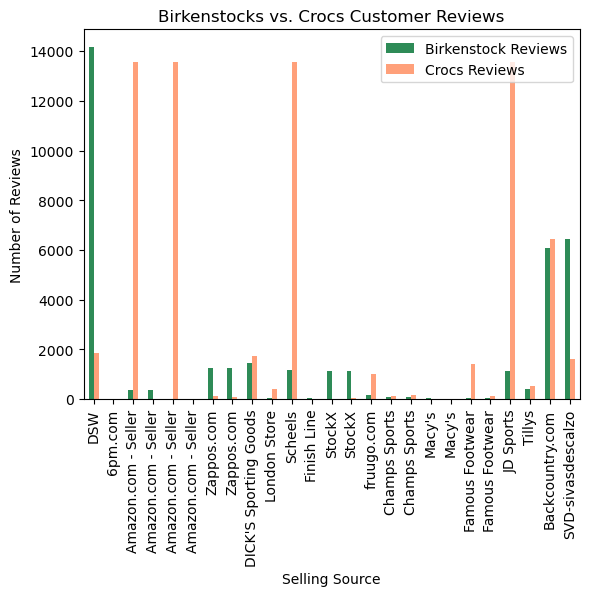

In [55]:
#Selling Source vs. Review for Birk and Crocs 
croc_birk_df.reset_index().plot(
    x="Selling Source", y=["Birkenstock Reviews", "Crocs Reviews"], kind="bar",color=["seagreen","lightsalmon"]
)
plt.title("Birkenstocks vs. Crocs Customer Reviews")
plt.xlabel("Selling Source")
plt.ylabel("Number of Reviews")
plt.savefig("data/croc_birk_CR.png")
plt.show()

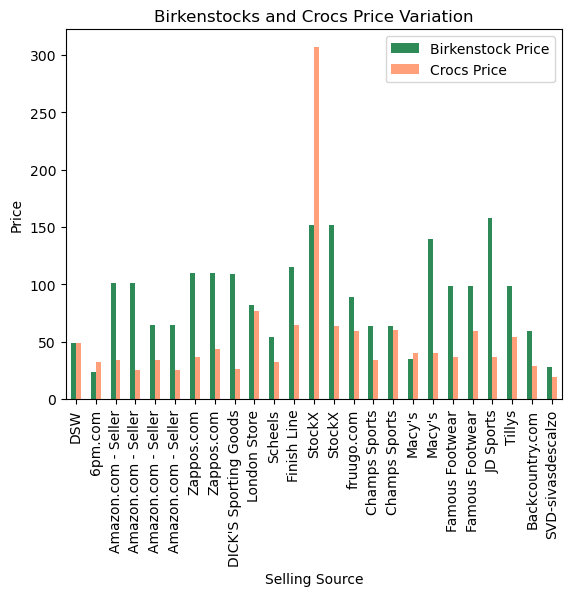

In [54]:
#Selling Source vs. Price for Birk and Crocs
croc_birk_df.reset_index().plot(
    x="Selling Source", y=["Birkenstock Price", "Crocs Price"], kind="bar",color=["seagreen","lightsalmon"]
)
plt.title("Birkenstocks and Crocs Price Variation")
plt.xlabel("Selling Source")
plt.ylabel("Price")
plt.savefig("data/croc_birk_price.png")
plt.show()

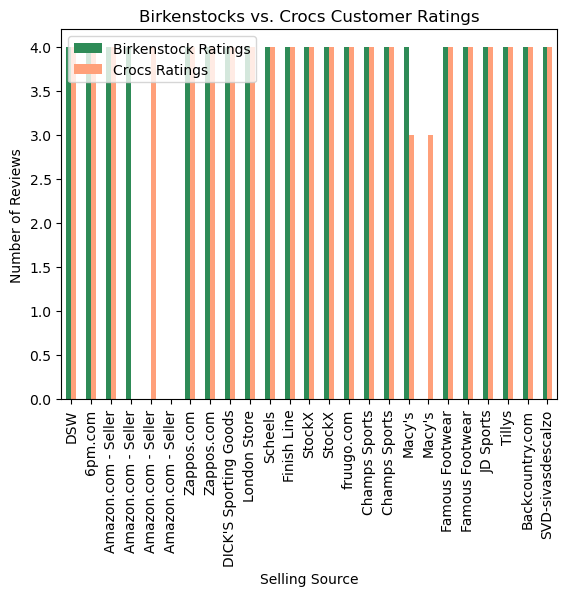

In [53]:
#Selling Source vs Rating for Birk and Crocs
croc_birk_df.reset_index().plot(
    x="Selling Source", y=["Birkenstock Ratings","Crocs Ratings"], kind="bar", color=["seagreen","lightsalmon"]

)

plt.title("Birkenstocks vs. Crocs Customer Ratings")
plt.xlabel("Selling Source")
plt.ylabel("Number of Reviews")
plt.savefig("data/croc_birk_CRating.png")
plt.show()

# Box Plots Showing Ratings, Reviews, and Price for Both Crocs and Birkenstocks

In [37]:
# crocs
# states
states = {
    'AK': 'Alaska',
    'AL': 'Alabama',
    'AR': 'Arkansas',
    'AZ': 'Arizona',
    'CA': 'California',
    'CO': 'Colorado',
    'CT': 'Connecticut',
    'DC': 'District of Columbia',
    'DE': 'Delaware',
    'FL': 'Florida',
    'GA': 'Georgia',
    'HI': 'Hawaii',
    'IA': 'Iowa',
    'ID': 'Idaho',
    'IL': 'Illinois',
    'IN': 'Indiana',
    'KS': 'Kansas',
    'KY': 'Kentucky',
    'LA': 'Louisiana',
    'MA': 'Massachusetts',
    'MD': 'Maryland',
    'ME': 'Maine',
    'MI': 'Michigan',
    'MN': 'Minnesota',
    'MO': 'Missouri',
    'MS': 'Mississippi',
    'MT': 'Montana',
    'NC': 'North Carolina',
    'ND': 'North Dakota',
    'NE': 'Nebraska',
    'NH': 'New Hampshire',
    'NJ': 'New Jersey',
    'NM': 'New Mexico',
    'NV': 'Nevada',
    'NY': 'New York',
    'OH': 'Ohio',
    'OK': 'Oklahoma',
    'OR': 'Oregon',
    'PA': 'Pennsylvania',
    'RI': 'Rhode Island',
    'SC': 'South Carolina',
    'SD': 'South Dakota',
    'TN': 'Tennessee',
    'TX': 'Texas',
    'UT': 'Utah',
    'VA': 'Virginia',
    'VT': 'Vermont',
    'WA': 'Washington',
    'WI': 'Wisconsin',
    'WV': 'West Virginia',
    'WY': 'Wyoming'
}
state_abrev = {v: k for k, v in states.items()}

# read in cities 
# with open(<filename>, 'r') as fr: 
with open('data/Census_City100.csv', 'r') as fr:
    reader = csv.reader(fr)
    lines = []
    for line in reader:
        lines.append(line)

cities=[]
for idx, x in enumerate(lines):
    if idx == 0:
        continue
    abrev = state_abrev[x[2][1:len(x[2])]]
    tmp_name = x[1] + ', ' + abrev
    cities.append(tmp_name)


print(cities)


['New York, NY', 'Los Angeles, CA', 'Chicago, IL', 'Houston, TX', 'Phoenix, AZ', 'Philadelphia, PA', 'San Antonio, TX', 'San Diego, CA', 'Dallas, TX', 'San Jose, CA', 'Austin, TX', 'Jacksonville, FL', 'Fort Worth, TX', 'Columbus, OH', 'Indianapolis, IN', 'Charlotte, NC', 'San Francisco, CA', 'Seattle, WA', 'Denver, CO', 'Oklahoma, OK', 'Nashville, TN', 'El Paso, TX', 'Washington, DC', 'Boston, MA', 'Las Vegas, NV', 'Portland, OR', 'Detroit, MI', 'Louisville, KY', 'Memphis, TN', 'Baltimore, MD', 'Milwaukee, WI', 'Albuquerque, NM', 'Fresno, CA', 'Tucson, AZ', 'Sacramento, CA', 'Mesa, AZ', 'Kansas, MO', 'Atlanta, GA', 'Omaha, NE', 'Colorado Springs, CO', 'Raleigh, NC', 'Virginia Beach, VA', 'Long Beach, CA', 'Miami, FL', 'Oakland, CA', 'Minneapolis, MN', 'Tulsa, OK', 'Bakersfield, CA', 'Wichita, KS', 'Arlington, TX', 'Aurora, CO', 'Tampa, FL', 'New Orleans, LA', 'Cleveland, OH', 'Anaheim, CA', 'Urban Honolulu CDP, HI', 'Henderson, NV', 'Stockton, CA', 'Lexington-Fayette urban county, KY',

In [38]:
# make api requests & get data
google_api_key = "385d42a61ed0f0d2baf0c09ec5e206d0bc9ba55f18baad435e7b6f079da56bce"
api_link = 'https://serpapi.com/search'

cities_params = []
for city in cities:
    tmp = {"engine": "google_shopping", "q": "Crocs", "location": city, "api_key": google_api_key}
    cities_params.append(tmp)


top_cities = cities[0:10]
top_cities_params = cities_params[0:10]

crocs_response_list= []
for param in top_cities_params:
    temp_req = requests.get(api_link, params=param)
    print(temp_req)
    crocs_response_list.append(temp_req)

<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>


In [39]:
# pull out data I want 
data_dict = {'City': [], 'Price': [], 'Rating': [], 'Review': []}

for idx, response in enumerate(crocs_response_list):
    city = top_cities[idx]
   
    tmp_res = response.json()
    shopping_res = tmp_res['shopping_results']
    for result in shopping_res:
        price = float(result['extracted_price'])

        try:
            rating = float(result['rating'])
            review = int(result['reviews'])
            data_dict['City'].append(city)
            data_dict['Price'].append(price)
            data_dict['Rating'].append(rating)
            data_dict['Review'].append(review)
        except:
            print('No rating found')
        
print(len(data_dict['Price']))
    

No rating found
No rating found
No rating found
No rating found
No rating found
No rating found
No rating found
No rating found
No rating found
No rating found
No rating found
No rating found
No rating found
No rating found
No rating found
No rating found
No rating found
No rating found
No rating found
No rating found
No rating found
No rating found
No rating found
No rating found
No rating found
No rating found
No rating found
No rating found
No rating found
No rating found
No rating found
No rating found
No rating found
No rating found
No rating found
No rating found
No rating found
No rating found
No rating found
No rating found
No rating found
No rating found
No rating found
No rating found
No rating found
No rating found
No rating found
No rating found
No rating found
No rating found
No rating found
No rating found
No rating found
No rating found
No rating found
No rating found
No rating found
No rating found
No rating found
No rating found
No rating found
No rating found
No ratin

In [40]:
# make pandas dataframe
data_df = pd.DataFrame.from_dict(data_dict)
data_df

City  Price  Rating  Review
0    New York, NY  26.24     4.8    1723
1    New York, NY  70.00     3.7       3
2    New York, NY  25.25     4.6   13555
3    New York, NY  35.00     4.8    1723
4    New York, NY  49.99     4.6   15477
..            ...    ...     ...     ...
487  San Jose, CA  44.99     4.7    1797
488  San Jose, CA  44.42     4.6   15477
489  San Jose, CA  34.34     4.7     510
490  San Jose, CA  57.99     4.6   15477
491  San Jose, CA  50.00     4.4     365

[492 rows x 4 columns]

In [41]:
# potentially more data cleanup
trying = data_df[data_df['City'] =='New York, NY']
city_df_list = []


for new in top_cities:
    city_df_list.append(data_df[data_df['City']== new])

In [42]:
# plotting data
prices_lol = []
ratings_lol = []
reviews_lol = []

for idxa, a in enumerate(city_df_list):
    prices_lol.append(city_df_list[idxa]['Price'].tolist())
    ratings_lol.append(city_df_list[idxa]['Rating'].tolist())
    reviews_lol.append(city_df_list[idxa]['Review'].tolist())



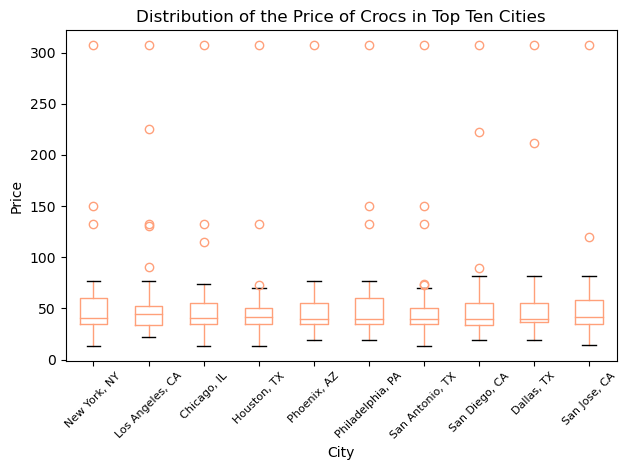

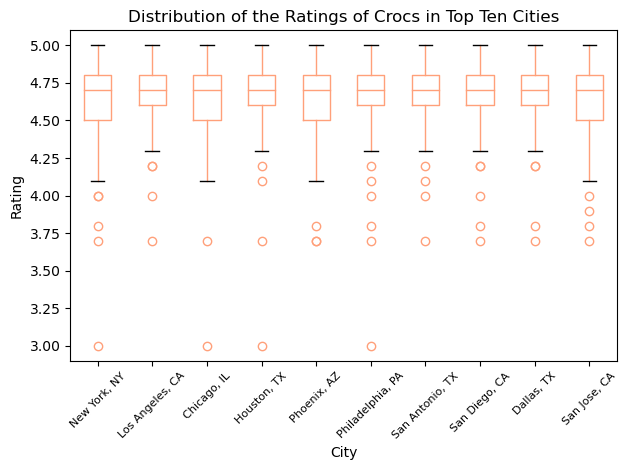

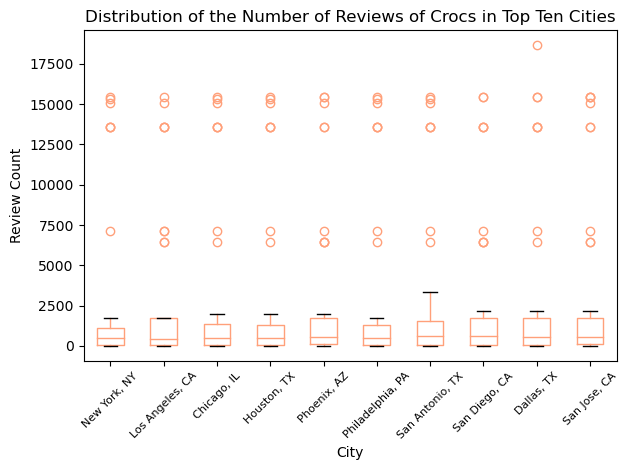

In [43]:
figure1 = plt.figure()
# temp = city_df_list[0]['Price'].tolist()
c='lightsalmon'
plt.boxplot(prices_lol,labels=top_cities,flierprops=dict(color = c,markeredgecolor=c),whiskerprops=dict(color=c),boxprops=dict(color=c),medianprops=dict(color=c))
plt.xticks(rotation=45, fontsize=8)
plt.xlabel('City')
plt.ylabel('Price')
plt.title('Distribution of the Price of Crocs in Top Ten Cities')
plt.tight_layout()
plt.savefig('price_crocs.png')
plt.show()

figure2 = plt.figure()
# temp = city_df_list[0]['Price'].tolist()

plt.boxplot(ratings_lol,labels=top_cities,flierprops=dict(color = c,markeredgecolor=c),whiskerprops=dict(color=c),boxprops=dict(color=c),medianprops=dict(color=c))
plt.xticks(rotation=45, fontsize=8)
plt.xlabel('City')
plt.ylabel('Rating')
plt.title('Distribution of the Ratings of Crocs in Top Ten Cities')
plt.tight_layout()
plt.savefig('rating_crocs.png')
plt.show()

figure3 = plt.figure()
# temp = city_df_list[0]['Price'].tolist()

plt.boxplot(reviews_lol,labels=top_cities,flierprops=dict(color = c,markeredgecolor=c),whiskerprops=dict(color=c),boxprops=dict(color=c),medianprops=dict(color=c))
plt.xticks(rotation=45, fontsize=8)
plt.xlabel('City')
plt.ylabel('Review Count')
plt.title('Distribution of the Number of Reviews of Crocs in Top Ten Cities')
plt.tight_layout()
plt.savefig('review_crocs.png')
plt.show()

In [44]:
#Birkenstocks
cities_params = []
for city in cities:
    tmp = {"engine": "google_shopping", "q": "Birkenstocks", "location": city, "api_key": google_api_key}
    cities_params.append(tmp)

top_cities = cities[0:10]
top_cities_params = cities_params[0:10]

birks_response_list= []
for param in top_cities_params:
    temp_req = requests.get(api_link, params=param)
    print(temp_req)
    birks_response_list.append(temp_req)

<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>


In [45]:
# pull out data I want 
data_dict = {'City': [], 'Price': [], 'Rating': [], 'Review': []}

for idx, response in enumerate(birks_response_list):
    city = top_cities[idx]
    tmp_res = response.json()
    shopping_res = tmp_res['shopping_results']
    for result in shopping_res:
        price = float(result['extracted_price'])
        try:
            rating = float(result['rating'])
            review = int(result['reviews'])
            data_dict['City'].append(city)
            data_dict['Price'].append(price)
            data_dict['Rating'].append(rating)
            data_dict['Review'].append(review)
        except:
            print('No rating found')
        
print(len(data_dict['Price']))

No rating found
No rating found
No rating found
No rating found
No rating found
No rating found
No rating found
No rating found
No rating found
No rating found
No rating found
No rating found
No rating found
No rating found
No rating found
No rating found
No rating found
No rating found
No rating found
No rating found
No rating found
No rating found
No rating found
No rating found
No rating found
No rating found
No rating found
No rating found
No rating found
No rating found
No rating found
No rating found
No rating found
No rating found
No rating found
No rating found
No rating found
No rating found
No rating found
No rating found
No rating found
No rating found
No rating found
No rating found
No rating found
No rating found
No rating found
No rating found
No rating found
No rating found
No rating found
No rating found
No rating found
No rating found
No rating found
No rating found
No rating found
No rating found
No rating found
No rating found
No rating found
No rating found
No ratin

In [46]:
# make pandas dataframe
data_df = pd.DataFrame.from_dict(data_dict)
data_df

City   Price  Rating  Review
0    New York, NY   59.95     4.7     151
1    New York, NY  190.00     4.5    6992
2    New York, NY   59.95     4.6      11
3    New York, NY   24.75     4.8       8
4    New York, NY   79.99     4.7    2526
..            ...     ...     ...     ...
506  San Jose, CA  152.68     4.6     437
507  San Jose, CA  119.99     4.7     661
508  San Jose, CA  100.00     4.4      30
509  San Jose, CA  130.00     3.7      22
510  San Jose, CA   49.20     4.5    6050

[511 rows x 4 columns]

In [47]:
# potentially more data cleanup
trying = data_df[data_df['City'] =='New York, NY']
city_df_list = []

for new in top_cities:
    city_df_list.append(data_df[data_df['City']== new])

In [48]:
# plotting data
prices_lol = []
ratings_lol = []
reviews_lol = []

for idxa, a in enumerate(city_df_list):
    prices_lol.append(city_df_list[idxa]['Price'].tolist())
    ratings_lol.append(city_df_list[idxa]['Rating'].tolist())
    reviews_lol.append(city_df_list[idxa]['Review'].tolist())


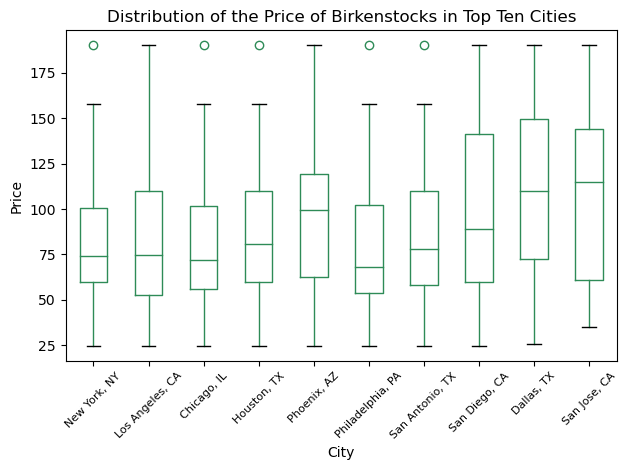

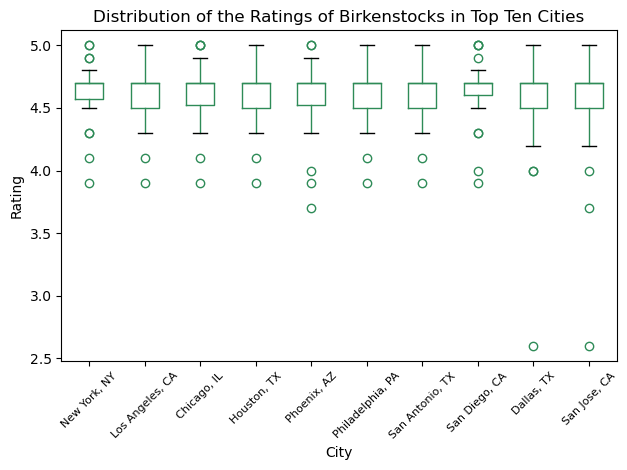

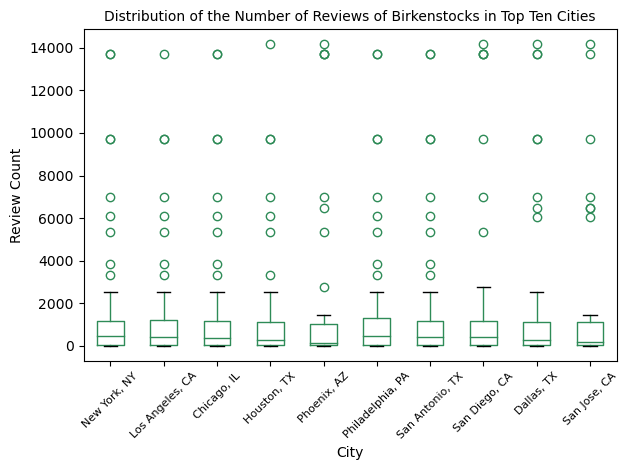

In [49]:
figure1 = plt.figure()
# temp = city_df_list[0]['Price'].tolist()
c='seagreen'
plt.boxplot(prices_lol,labels=top_cities,flierprops=dict(color = c,markeredgecolor=c),whiskerprops=dict(color=c),boxprops=dict(color=c),medianprops=dict(color=c))
plt.xticks(rotation=45, fontsize=8)
plt.xlabel('City')
plt.ylabel('Price')
plt.title('Distribution of the Price of Birkenstocks in Top Ten Cities')
plt.tight_layout()
plt.savefig('price_birks.png')
plt.show()

figure2 = plt.figure()
# temp = city_df_list[0]['Price'].tolist()

plt.boxplot(ratings_lol,labels=top_cities,flierprops=dict(color = c,markeredgecolor=c),whiskerprops=dict(color=c),boxprops=dict(color=c),medianprops=dict(color=c))
plt.xticks(rotation=45, fontsize=8)
plt.xlabel('City')
plt.ylabel('Rating')
plt.title('Distribution of the Ratings of Birkenstocks in Top Ten Cities')
plt.tight_layout()
plt.savefig('rating_birks.png')
plt.show()

figure3 = plt.figure()
# temp = city_df_list[0]['Price'].tolist()

plt.boxplot(reviews_lol,labels=top_cities,flierprops=dict(color = c,markeredgecolor=c),whiskerprops=dict(color=c),boxprops=dict(color=c),medianprops=dict(color=c))
plt.xticks(rotation=45, fontsize=8)
plt.xlabel('City')
plt.ylabel('Review Count')
plt.title('Distribution of the Number of Reviews of Birkenstocks in Top Ten Cities',fontsize=10)
plt.tight_layout()
plt.savefig('review_birks.png')
plt.show()